### Setup

In [1]:
import pickle,gzip,math,os,time,shutil,torch,random
import fastcore.all as fc,matplotlib as mpl,numpy as np,matplotlib.pyplot as plt, lovely_tensors as lt
from functools import partial


import torchvision.transforms.functional as TF,torch.nn.functional as F
from torchvision import transforms
from torch import tensor,nn,optim
from torch.optim import lr_scheduler
from torcheval.metrics import MulticlassAccuracy, Throughput
from datasets import load_dataset,load_dataset_builder


from miniai.datasets import *
from miniai.conv import *
from miniai.learner import *
from miniai.activations import *
from miniai.augment import *
from miniai.init import *
from miniai.sgd import *
from miniai.resnet import *

torch.set_printoptions(precision=2, linewidth=140, sci_mode=False)
torch.manual_seed(1)
mpl.rcParams['image.cmap'] = 'gray_r'


import logging
logging.disable(logging.WARNING)

lt.monkey_patch()
fc.defaults.cpus=6

### Load Data

In [2]:
xl,yl = 'image','label'
name = "fashion_mnist"
xmean,xstd = 0.28,0.35
dsd = load_dataset(name)
@inplace
def transformi(b): b[xl] = [(TF.to_tensor(o)-xmean)/xstd for o in b[xl]]

bs = 10_000
tds = dsd.with_transform(transformi)
dls = DataLoaders.from_dd(tds, bs, num_workers=fc.defaults.cpus)

  0%|          | 0/2 [00:00<?, ?it/s]

### Model

In [3]:
def get_cnn(act=nn.ReLU, nfs=(8,16,32,64,128), norm=nn.BatchNorm2d):
    layers = [conv(1, 8, stride=1, act=act, norm=norm)]
    layers += [conv(nfs[i], nfs[i+1], act=act, norm=norm) for i in range(len(nfs)-1)]
    return nn.Sequential(*layers, conv(nfs[-1], 10, act=None, norm=norm, bias=True), nn.Flatten()).to("cuda")

### Training

accuracy,loss,epoch,train
0.530,1.633,0,train
0.636,3.008,0,eval


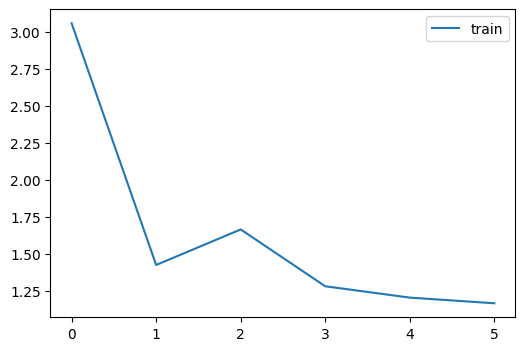

In [4]:
set_seed(31)
# metrics = MetricsCB(accuracy=MulticlassAccuracy(), throughput=Throughput())
lr,epochs =  1e-1, 1
metrics = MetricsCB(accuracy=MulticlassAccuracy())
astats = ActivationStats(fc.risinstance(GeneralRelu))
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
xtra = [BatchSchedCB(sched)]
cbs = [DeviceCB(), metrics, ProgressCB(plot=True), astats]
act_gr = partial(GeneralRelu, leak=0.1, sub=0.4)
iw = partial(init_weights, leaky=0.1)
model = get_cnn(act_gr, norm=nn.BatchNorm2d).apply(iw)
learn = TrainLearner(model, dls, F.cross_entropy, lr=lr, cbs=cbs+xtra, opt_func=optim.AdamW)
learn.fit(epochs)

In [6]:
set_seed(28)
lr,epochs =  1e-1, 1

metrics = MetricsCB(accuracy=MulticlassAccuracy(), throughput=Throughput())

astats = ActivationStats(fc.risinstance(GeneralRelu))
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
xtra = [BatchSchedCB(sched)]
cbs = [DeviceCB(), metrics, ProgressCB(plot=True), astats]
act_gr = partial(GeneralRelu, leak=0.1, sub=0.4)
iw = partial(init_weights, leaky=0.1)
model = get_cnn(act_gr, norm=nn.BatchNorm2d).apply(iw)
learn = TrainLearner(model, dls, F.cross_entropy, lr=lr, cbs=cbs+xtra, opt_func=optim.AdamW)
learn.fit(epochs)

RuntimeError: Boolean value of Tensor with more than one value is ambiguous

In [ ]:
cbs = fc.L([MetricsCB(throughput=Throughput())])
cbs